**MNIST Handwritten digit Classification**

# Setup

Check Versions

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn >= 1.0.1:

In [1]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

Define the default font sizes to make the figures prettier.

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/classification` folder (if it doesn't already exist), and define the `save_fig()` function to save the figures in high resolution.

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [6]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [7]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
X.shape

(70000, 784)

In [10]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [11]:
y.shape

(70000,)

In [12]:
28*28

784

In [13]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

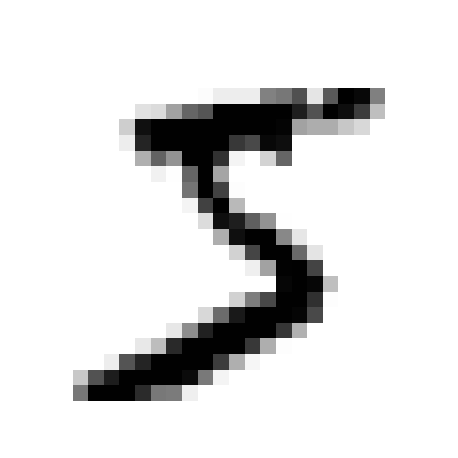

In [14]:
some_digit = X[0]
plot_digit(some_digit)
save_fig("some_digit_plot")
plt.show()

In [15]:
y[0]

'5'

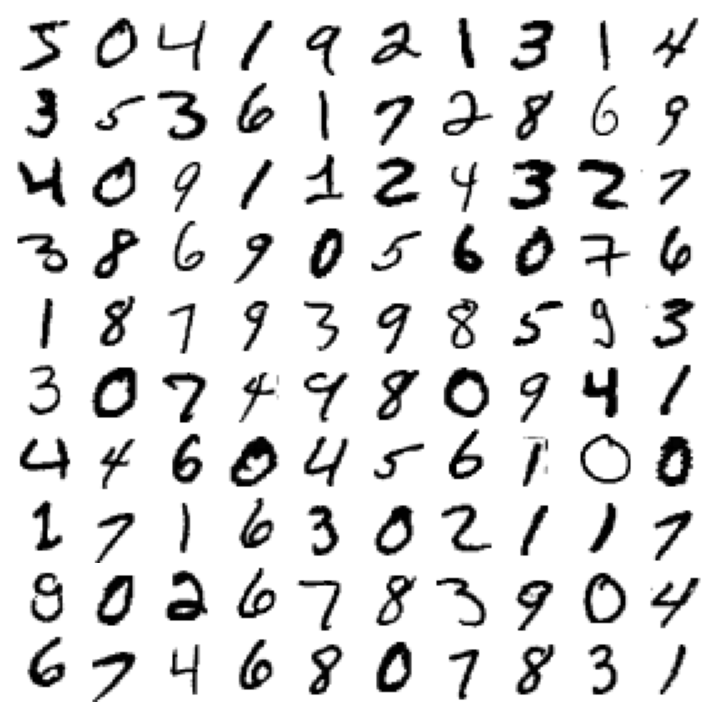

In [16]:
plt.figure(figsize=(9,9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx+1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

In [6]:
# train-test split
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [18]:
y_train_5 = (y_train == '5') # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [19]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [20]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [21]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [22]:
# Implementing Cross-Validation with ourself.
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # add shuffle=True 
                                      # if dataset is not already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [23]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

print(any(dummy_clf.predict(X_train)))

False


In [24]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

## Confusion Matrix

In [25]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [26]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [27]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

This means,
53892 of them were correctly classified as non-5s ( ie. True Negatives)  
687 were wrongly correctly classified as 5s ( ie. False Positives)  
1891 were wrongly classified as non-5s ( ie. False Negatives)  
3530 of them were correctly classified as 5s ( ie. True Positives)

In [28]:
y_train_perfect_predictions = y_train_5  # Pretend we reach Perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)


array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

 More Concise Metric, Precision and Recall:

$$ \text{precision} = \frac{TP}{TP + FP} $$

$$ \text{recall} = \frac{TP}{TP + FN} $$

In [29]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (3530 + 687)

0.8370879772350012

In [30]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (3530 + 1891)

0.6511713705958311

When it claims that image represents a 5, it is correct only 83.7% of the time.
More-over, it only detects 65.1% of the 5s

F1 Score:

$$ {F_1} = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 * \frac{precision * recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}} $$

In [31]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [32]:
# extra code – this cell also computes the f1 score
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

## Precision/Recall Trade-off

In [33]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [34]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [35]:
y_some_digit_pred

array([ True])

In [36]:
sgd_clf.predict([some_digit])

array([ True])

In [37]:
y_scores > 0

array([ True])

In [38]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [39]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [40]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [41]:
# using precision_recall_curve() function to compute
# precision and recall of all possible thresholds.

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

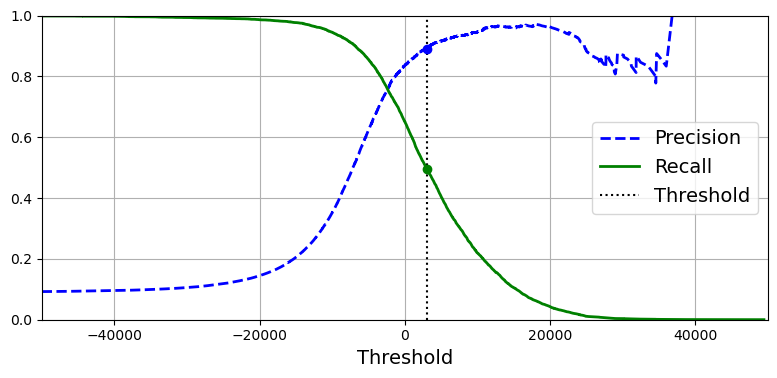

In [42]:
plt.figure(figsize=(8,4))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
plt.vlines(threshold, 0, 1.0, 'k', 'dotted', label='Threshold')

idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], 'bo')
plt.plot(thresholds[idx], recalls[idx], 'go')
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel('Threshold')
plt.legend(loc='center right')
save_fig('precision_recall_vs_threshold_plot')

plt.show()

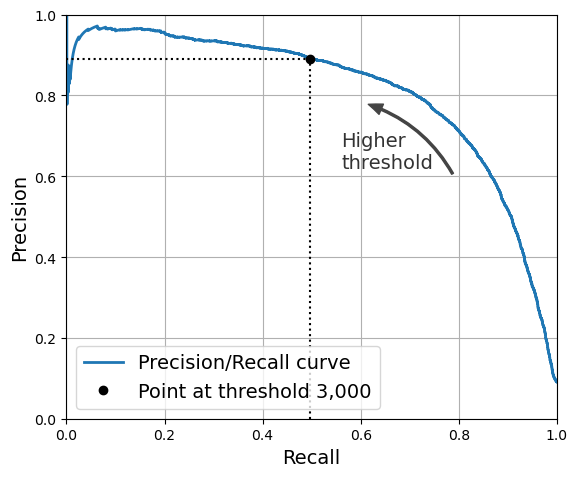

In [43]:
import matplotlib.patches as patches

plt.figure(figsize=(6,5))

plt.plot(recalls, precisions, linewidth=2, label='Precision/Recall curve')

plt.plot([recalls[idx], recalls[idx]], [0.0, precisions[idx]], 'k:')
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], 'k:')
plt.plot([recalls[idx]], [precisions[idx]], 'ko', 
         label='Point at threshold 3,000')
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, 'Higher\nthreshold', color='#333333')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc='lower left')
save_fig("precision_vs_recall_plot")
plt.show()

In [44]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [45]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [46]:
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [47]:
# lets check this prediction's precision and recall
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [48]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## The ROC Curve

Receiver Operating Characteristics

In [49]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

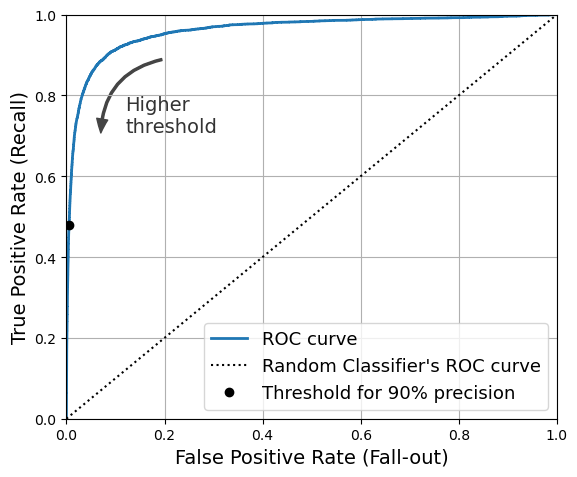

In [50]:
# plotting ROC curve / FPR vs TPR
# since thresholds are listed in descending order, we use <= instead of >=

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k:', label="Random Classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko",  label="Threshold for 90% precision")

# extra code - just beautifies and saves Figure
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3, rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel("False Positive Rate (Fall-out)")
plt.ylabel("True Positive Rate (Recall)")
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc='lower right', fontsize=13)
save_fig("roc_curve_plot")

plt.show()

The dotted line represents the purely random classifier.  
A good classifier stays as far away from that line as possible (towards top-left corner)

In [51]:
# area under the curve

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

A perfect classifier will have ROC AUC equal to 1,  
whereas a purely random classifier will have ROC AUC equal to 0.5

<b>`RandomForest Classifier`</b>

In [52]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [53]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [54]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The model predicts that the first image is positive with 89% probability,  
and it predicts that the second image is negative with 99% probability.

These are estimated probabilities. Among the images that the model classified as positive with a probability between 50% and 60%, there are actually about 94% positive images.

In [55]:
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60].sum() / idx_50_to_60.sum()):.1%}")

94.0%


In [56]:
# The second column contains the estimated probabilities for the positive class.
# So let's pass them to the precision_recall_curve() function.

y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

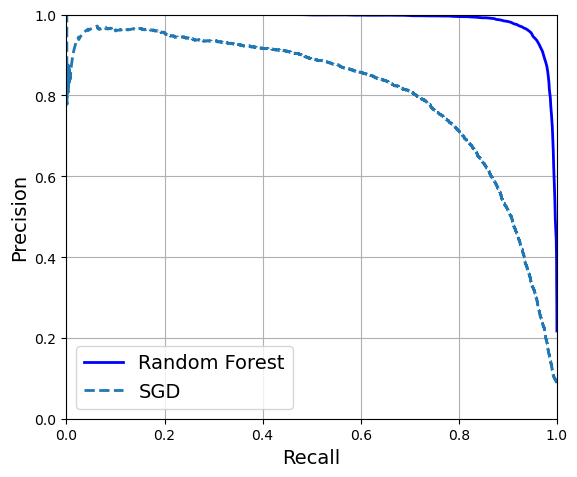

In [57]:
plt.figure(figsize=(6, 5))

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()

plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")
plt.show()

In [58]:
# Computing ROC AUC score and F1 score

y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba >= 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [59]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [60]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [61]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

In [62]:
y_train_pred_forest

array([ True, False, False, ...,  True, False, False])

# Multiclass Classification

SVMs do not scale well on large datasets, so let's only train on the first 2,000 instances, or else this section will take a very long time to run:

In [63]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [64]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [65]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [66]:
class_id = some_digit_scores.argmax()
class_id

5

In [67]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [68]:
svm_clf.classes_[class_id]

'5'

In [69]:
svm_clf.decision_function_shape

'ovr'

If you want `decision_function()` to return all 45 scores, you can set the `decision_function_shape` hyperparameter to `"ovo"`. The default value is `"ovr"`, but don't let this confuse you: `SVC` always uses OvO for training. This hyperparameter only affects whether or not the 45 scores get aggregated or not:

In [70]:
svm_clf.decision_function_shape = 'ovo'
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

In [71]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [72]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [73]:
len(ovr_clf.estimators_)

10

In [74]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [75]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [76]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [77]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

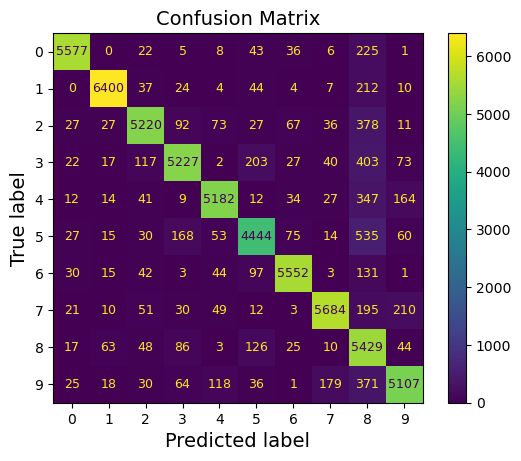

In [78]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.title("Confusion Matrix")
plt.show()

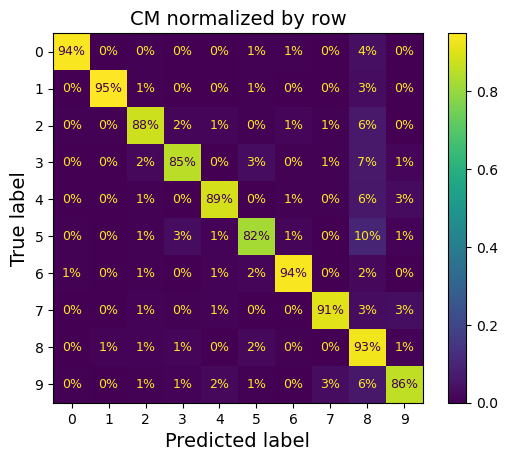

In [79]:
# normalizing the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, 
                                        normalize="true", values_format=".0%")
plt.title("CM normalized by row")
plt.show()

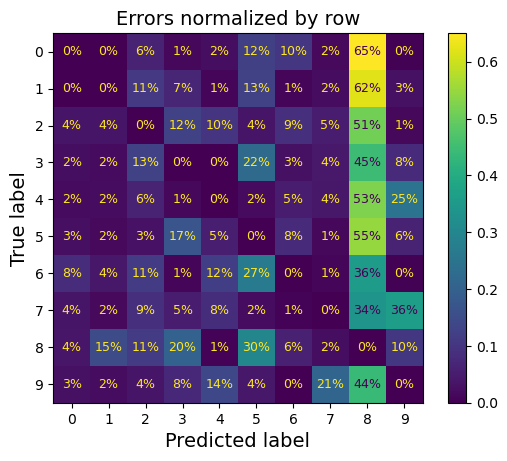

In [80]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                         normalize="true", values_format=".0%")
plt.title("Errors normalized by row")
plt.show()

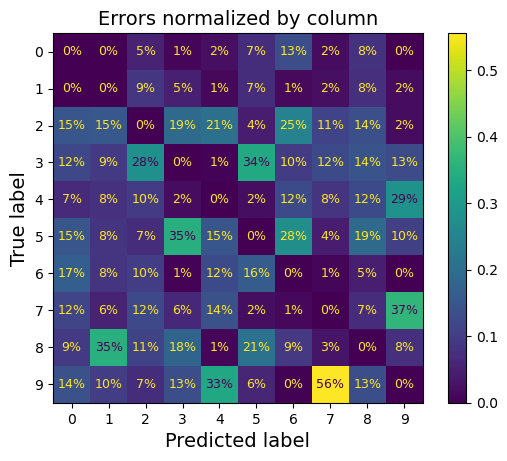

In [81]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                         normalize="pred", values_format=".0%")
plt.title("Errors normalized by column")
plt.show()

In [82]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

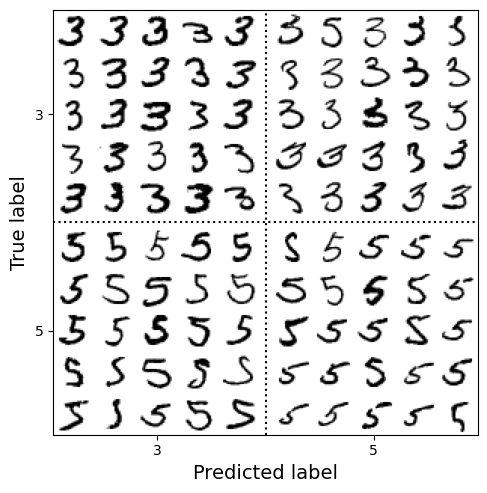

In [83]:
# some images of 3s and 5s organized like confusion matrix

size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()

# Multilabel Classification

In [84]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]  # concatenation
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [85]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [86]:
knn_clf.predict([some_digit])

/home/sandesh/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([[False,  True]])

It gets it right. The digit 5 is indeed not large (False) and odd (True) 

In [87]:
# Evaluation with F1 score

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel,  cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

/home/sandesh/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/sandesh/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

0.976410265560605

In [88]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [89]:
chain_clf.predict([some_digit])

array([[0., 1.]])

# Multioutput Classification

Creating a noise filter system.

In [90]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

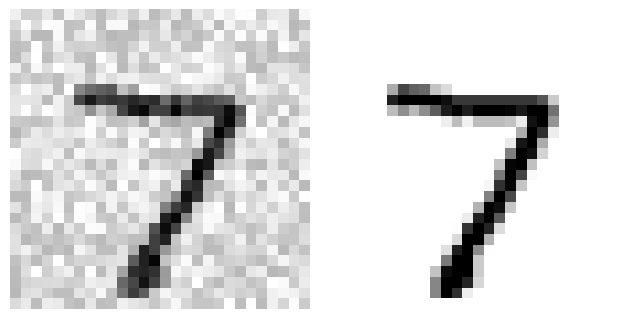

In [91]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

In [92]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

/home/sandesh/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


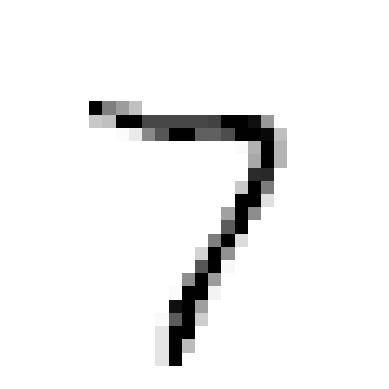

In [94]:
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()

# Exercises

## 1. An MNIST Classifier With Over 97% Accuracy

Exercise: _Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the `KNeighborsClassifier` works quite well for this task; you just need to find good hyperparameter values (try a grid search on the `weights` and `n_neighbors` hyperparameters)._

Let's start with a simple K-Nearest Neighbors classifier and measure its performance on the test set. This will be our baseline:

In [105]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

/home/sandesh/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.9688

Let's see if tuning the hyperparameter can help. To speed up the search, let's train only on first 10,000 images.

In [108]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5, 6]}]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn_clf,
                           param_grid=param_grid,
                           cv=3)
grid_search.fit(X_train[:10000], y_train[:10000])

/home/sandesh/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/sandesh/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [113]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [114]:
grid_search.best_score_

0.9397994088551026

Score dropped. Let's take best model and train on full dataset.

In [116]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9714

Great. We reached our goal of 97% accuracy.

## 2. Data Augmentation

Exercise: _Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. You can use the `shift()` function from the `scipy.ndimage` module. For example, `shift(image, [2, 1], cval=0)` shifts the image two pixels down and one pixel to the right. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called _data augmentation_ or _training set expansion_._

In [7]:
from scipy.ndimage import shift

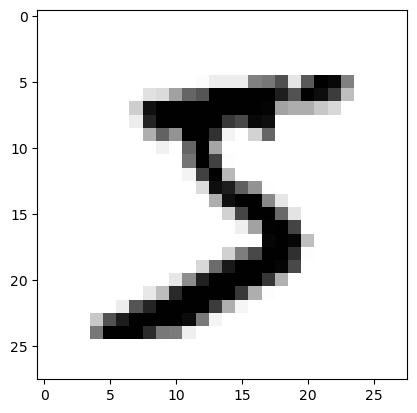

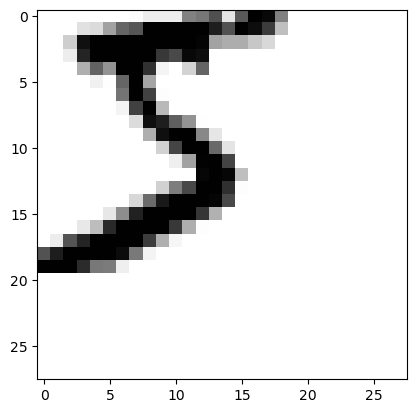

In [14]:
plt.imshow(X_train[0].reshape(28,28), cmap="binary")
plt.show()

plt.imshow(shift(X_train[0].reshape(28,28), shift=[-5, -5], cval=0, mode="constant"), cmap="binary")
plt.show()

In [39]:
# defining a function to shift an image

def shift_image(image, dx, dy):
    image = image.reshape(28, 28)
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

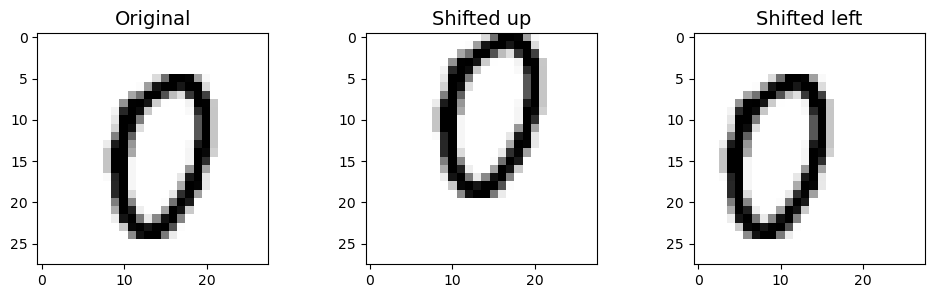

In [52]:
some_image = X_train[1000]
shifted_image_up = shift_image(some_image, 0, -5)
shifted_image_left = shift_image(some_image, -5, 0)

plt.figure(figsize=(12,3))

plt.subplot(131)
plt.title("Original")
plt.imshow(some_image.reshape(28,28),
           interpolation="nearest", cmap="binary")

plt.subplot(132)
plt.title("Shifted up")
plt.imshow(shifted_image_up.reshape(28,28),
           interpolation="nearest", cmap="binary")

plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28,28),
           interpolation="nearest", cmap="binary")

plt.show()